In [1]:
import sys
import os
import glob
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.set_random_seed(0)

In [2]:
n_hidden = 512
N = 2048
batch_size = 64
epochs = 2000

In [3]:
target_names = ['1', '2']
feature_names = ['x']

# Model

In [4]:
def create_hidden_layer(n_hidden, prev_layer, name, weights_initializer=tf.contrib.layers.xavier_initializer(),
                        biases_initializer=tf.zeros_initializer(), activation='relu'):
    W = tf.get_variable('W' + name, shape=[prev_layer.shape.as_list()[1], n_hidden], initializer=weights_initializer)
    b = tf.get_variable('b' + name, shape=[n_hidden], initializer=biases_initializer)
    if activation == 'relu':
        A = tf.nn.relu_layer(prev_layer, W, b, name='hidden_layer' + name)
    return W, b, A

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [6]:
with tf.variable_scope('x_placeholders'):
    x = tf.placeholder('float', shape=[None, len(feature_names)], name='input')
    
with tf.variable_scope('y_placeholders'):
    Y_true = {}
    for name in target_names:
        Y_true[name] = tf.placeholder('float', shape=[None, 1], name=name)

In [7]:
with tf.variable_scope('hidden'):
    W1, b1, A = create_hidden_layer(n_hidden, x, '1')
#     W2, b2, A = create_hidden_layer(n_hidden_2, A, '2')

In [8]:
with tf.variable_scope('output_weights'):
    output_weights = {}
    output_biases = {}
    for name in target_names:
        output_weights[name] = tf.get_variable(
            "W_" + name, shape=[A.shape.as_list()[1], 1], initializer=tf.contrib.layers.xavier_initializer())
        output_biases[name] = tf.get_variable(
            'b_' + name, shape=[], initializer=tf.zeros_initializer())

In [9]:
with tf.variable_scope('outputs'):
    Y_pred = {}
    for name in target_names:
        Y_pred[name] = tf.matmul(A, output_weights[name]) + output_biases[name]

For binary classification

    with tf.variable_scope('uncertainties'):
    uncertainties = {}
    for name in target_names:
        uncertainties[name] = tf.get_variable('uncertainties_' + name, initializer=tf.constant(1.0))

    with tf.variable_scope('loss'):
    loss = 0
    for key in Y_true:
        uncertainty = uncertainties[key]
        loss += tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(labels=Y_true[key], logits=Y_pred[key]/uncertainty))
        
For multi-class classification, replace the binary loss with softmax loss

In [10]:
# For Regression

with tf.variable_scope('log_vars'):
    log_vars = {}
    for name in target_names:
        log_vars[name] = tf.get_variable(name, shape=[], initializer=tf.zeros_initializer())
        
with tf.variable_scope('loss'):
    loss = 0
    for key in Y_true:
        log_var = log_vars[key]
        loss += tf.reduce_sum(tf.exp(-log_var) * tf.square(Y_pred[key] - Y_true[key]) + log_var, -1)
    loss = tf.reduce_mean(loss)

For binary classification

    with tf.variable_scope('validation'):
        Xval = tf.placeholder('float', shape=[None, len(feature_names)], name='Xval')
        Yval = tf.placeholder('float', shape=[None, 1], name='Yval')
        Aval = tf.nn.relu_layer(Xval, W1, b1, name='Val_layer1')
        Aval = tf.nn.relu_layer(Aval, W2, b2, name='Val_layer2')

        PredVal = tf.sigmoid(
            tf.matmul(Aval, output_weights["conversion_label"]) + output_biases["conversion_label"])  
        ScoreVal, update_ops = tf.metrics.auc(Yval, PredVal)

In [11]:
with tf.variable_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)

In [12]:
init = tf.global_variables_initializer()
# For AUC validation
# local_init = tf.local_variables_initializer()

# Evaluate on Synthetic Data

In [13]:
Q = 1
D1 = 1  # first output
D2 = 1  # second output

In [14]:
def gen_data(N):
    X = np.random.randn(N, Q)
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    w2 = 3
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2

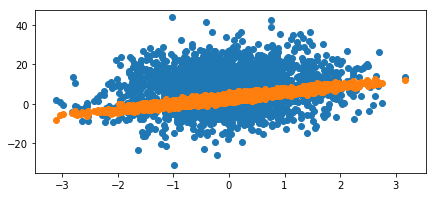

In [15]:
import pylab
%matplotlib inline

X, Y1, Y2 = gen_data(N)
pylab.figure(figsize=(7, 3))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])
pylab.show()

# Data Generator

In [16]:
def data_gen(X, Y, batch_size=128):
    counter = 0
    max_iter = int(X.shape[0] / batch_size)
    items = Y.items()
    batch_Y = {}
    for i in range(max_iter):
        batch_X = X[counter:counter+batch_size, :]
        for key, val in items:
            batch_Y[key] = val[counter:counter+batch_size, :]
        yield batch_X, batch_Y
        counter += batch_size
    batch_X = X[counter:counter+batch_size, :]
    for key, val in items:
        batch_Y[key] = val[counter:counter+batch_size, :]
    if batch_X.size != 0:
        yield batch_X, batch_Y

# Training

In [17]:
losses = []

init.run()
# local_init.run()
for i in range(epochs):
    tmp = 0
    step = 0
    gen = data_gen(X, {"1": Y1, "2": Y2}, batch_size=batch_size)
    for batch_X, batch_Y in gen:
        feed_dict = {x: batch_X}
        for key, val in batch_Y.items():
            feed_dict[Y_true[key]] = val
        _, l = sess.run([train_op, loss], feed_dict=feed_dict)
        tmp += l
        step += 1
    losses.append(tmp/step)
#     valscore, posnegs = sess.run([ScoreVal, update_ops], feed_dict={Xval: Xtest, Yval: ytest})
#     print("At epoch %d, Loss: %.4f, validation AUROC: %.4f" % (i, tmp/step, valscore))
    if i % 100 == 0:
        print("At epoch %d, Loss: %.4f" % (i, tmp/step))

At epoch 0, Loss: 163.2723
At epoch 100, Loss: 16.6841
At epoch 200, Loss: 7.9149
At epoch 300, Loss: 6.6120
At epoch 400, Loss: 6.5557
At epoch 500, Loss: 6.5548
At epoch 600, Loss: 6.5541
At epoch 700, Loss: 6.5535
At epoch 800, Loss: 6.5530
At epoch 900, Loss: 6.5526
At epoch 1000, Loss: 6.5522
At epoch 1100, Loss: 6.5518
At epoch 1200, Loss: 6.5514
At epoch 1300, Loss: 6.5510
At epoch 1400, Loss: 6.5507
At epoch 1500, Loss: 6.5503
At epoch 1600, Loss: 6.5500
At epoch 1700, Loss: 6.5497
At epoch 1800, Loss: 6.5494
At epoch 1900, Loss: 6.5491


In [18]:
# Found standard deviations (ground truth is 10 and 1):
np.exp(log_vars['1'].eval())**0.5, np.exp(log_vars['2'].eval())**0.5

(9.8657264141178498, 0.98553093146250581)